In [4]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"] = False

In [7]:
print('Total images for train:', len(os.listdir('D:/hackathon/train/train')))
print('Total images for test:', len(os.listdir('D:/hackathon/test/test')))
print('Without ships:', len(df[df['EncodedPixels'].isna()]))

Total images for train: 13000
Total images for test: 2000
Without: 6000


In [5]:
df = pd.read_csv('D:/hackathon/train_classification.csv')

In [6]:
df

,ImageId,EncodedPixels,IdCls
0,b223986d3.jpg,116 52 883 52 1651 52 2418 52 3186 52 3953 52 ...,1
1,b223986d3.jpg,286882 2 287650 4 288417 7 289185 9 289952 12 ...,1
2,21ce62cd8.jpg,7769 1 8535 4 9301 6 10068 8 10834 10 11601 12...,1
3,ed970aebc.jpg,41216 5 41984 10 42752 10 43520 10 44288 10 45...,1
4,ed970aebc.jpg,437709 5 438477 15 439245 20 440013 20 440781 ...,1
...,...,...,...
21138,c9a02350b.jpg,NaN,0
21139,6a47fcf7b.jpg,NaN,0
21140,f92c4fa3f.jpg,NaN,0
21141,4755d29d9.jpg,NaN,0


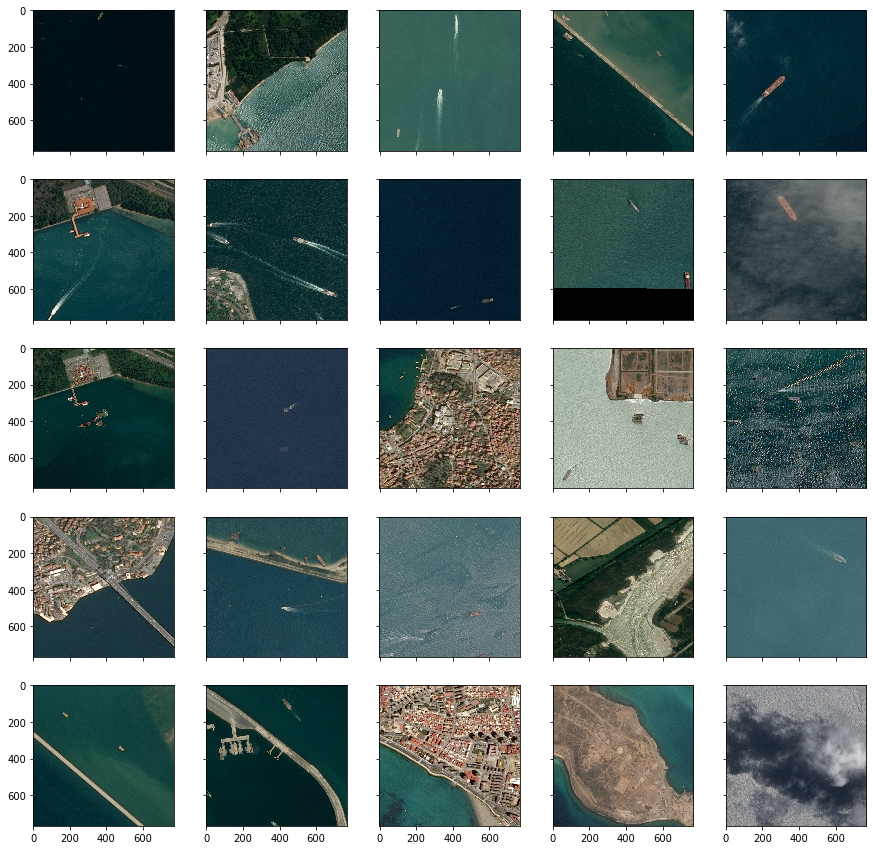

In [8]:
samples = df[~df['EncodedPixels'].isna()].sample(25)

fig, ax = plt.subplots(5, 5, figsize=(15, 15), sharex='col', sharey='row')

for i, idimg in enumerate(samples['ImageId']):
    col = i % 5
    row = i // 5
    
    path = 'D:/hackathon/train/train/{}'.format(idimg)
    img = cv2.imread(path)
    
    ax[row, col].imshow(img[...,[2,1,0]])

In [9]:
def rle_decode(mask_rle, shape=(768,768)):
  img = np.zeros(shape[0]*shape[1])
  s = mask_rle.split()
  starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
  starts -= 1
  ends = starts + lengths
  for lo, hi in zip(starts,ends):
      img[lo:hi] = 1
      
  img = img.reshape(shape).T # Needed to align to RLE direction
  return img

def masks_as_image(in_mask_list):
    all_masks = np.zeros((768, 768))
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [10]:
from sklearn.model_selection import train_test_split
masks = df.drop(df[df['EncodedPixels'].isnull()].index)
unique_img_ids = masks.groupby('ImageId').size().reset_index(name='Counts')

train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.05, 
                 stratify = unique_img_ids['Counts'],
                 random_state=42)

train_df = pd.merge(df, train_ids)
valid_df = pd.merge(df, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

14383 training masks
760 validation masks


In [21]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D

In [176]:
best_w = keras.callbacks.ModelCheckpoint('best_segnet.w',
                                        monitor='val_loss',
                                        verbose=0,
                                        save_best_only=True,
                                        save_weights_only=True,
                                        mode='auto',
                                        period=1)

last_w = keras.callbacks.ModelCheckpoint('last_segnet.w',
                                        monitor='val_loss',
                                        verbose=0,
                                        save_best_only=False,
                                        save_weights_only=True,
                                        mode='auto',
                                        period=1)

callbacks = [best_w, last_w]

Segnet neural net from https://arxiv.org/abs/1511.00561

In [422]:
inp = Input(shape=(768,768,3))

# first block
conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)

conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)


# second block
conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)

conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)


# third block
conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)

conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)

pool_3 = MaxPooling2D(2)(conv_3_2)


# fourth block
conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)

conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)

pool_4 = MaxPooling2D(2)(conv_4_2)


# fifth block
conv_5_1 = Conv2D(512, (3, 3), padding='same')(pool_4)
conv_5_1 = Activation('relu')(conv_5_1)

conv_5_2 = Conv2D(512, (3, 3), padding='same')(conv_5_1)
conv_5_2 = Activation('relu')(conv_5_2)

pool_5 = MaxPooling2D(2)(conv_4_2)


# first decoding block
up_1 = UpSampling2D(2, interpolation='bilinear')(pool_5)
conv_up_1_1 = Conv2D(512, (3, 3), padding='same')(up_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)

conv_up_1_2 = Conv2D(512, (3, 3), padding='same')(conv_up_1_1)
conv_up_1_2 = Activation('relu')(conv_up_1_2)


# second decoding block
up_2 = UpSampling2D(2, interpolation='bilinear')(pool_4)
conv_up_2_1 = Conv2D(256, (3, 3), padding='same')(up_2)
conv_up_2_1 = Activation('relu')(conv_up_2_1)

conv_up_2_2 = Conv2D(256, (3, 3), padding='same')(conv_up_2_1)
conv_up_2_2 = Activation('relu')(conv_up_2_2)


# third decoding block
up_3 = UpSampling2D(2, interpolation='bilinear')(pool_3)
conv_up_3_1 = Conv2D(128, (3, 3), padding='same')(up_3)
conv_up_3_1 = Activation('relu')(conv_up_3_1)

conv_up_3_2 = Conv2D(128, (3, 3), padding='same')(conv_up_3_1)
conv_up_3_2 = Activation('relu')(conv_up_3_2)


# fourth decoding block
up_4 = UpSampling2D(2, interpolation='bilinear')(pool_2)
conv_up_4_1 = Conv2D(64, (3, 3), padding='same')(up_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)

conv_up_4_2 = Conv2D(64, (3, 3), padding='same')(conv_up_4_1)
conv_up_4_2 = Activation('relu')(conv_up_4_2)


# fifth decoding block
up_5 = UpSampling2D(2, interpolation='bilinear')(conv_up_4_2)
conv_up_5_1 = Conv2D(32, (3, 3), padding='same')(up_5)
conv_up_5_1 = Activation('relu')(conv_up_5_1)

conv_up_5_2 = Conv2D(1, (3, 3), padding='same')(conv_up_5_1)
result = Activation('sigmoid')(conv_up_5_2)


segnet_model = Model(inputs=inp, outputs=result)
segnet_model.summary()

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 768, 768, 3)]     0         
_________________________________________________________________
conv2d_210 (Conv2D)          (None, 768, 768, 32)      896       
_________________________________________________________________
activation_210 (Activation)  (None, 768, 768, 32)      0         
_________________________________________________________________
conv2d_211 (Conv2D)          (None, 768, 768, 32)      9248      
_________________________________________________________________
activation_211 (Activation)  (None, 768, 768, 32)      0         
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 384, 384, 32)      0         
_________________________________________________________________
conv2d_212 (Conv2D)          (None, 384, 384, 64)    

In [179]:
import keras.backend as K
from keras.losses import binary_crossentropy

def IoU(y_true, y_pred, eps=1e-6):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( 2 * (intersection + eps) / (union + eps), axis=0)

def zero_IoU(y_true, y_pred):
    return IoU(1-y_true, 1-y_pred)

def agg_loss(in_gt, in_pred):
    return 1. / IoU(in_gt, in_pred) - 1

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)  


segnet_model.compile(optimizer=adam, loss=agg_loss, metrics=[IoU, 'binary_accuracy'])

In [180]:
def keras_generator(gen_df, batch_size=4):
    all_batches = list(gen_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = 'D:/hackathon/train/train/'+c_img_id
            c_img = cv2.imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            c_img = c_img[::1, ::1]
            c_mask = c_mask[::1, ::1]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

In [458]:
net = segnet_model.fit_generator(keras_generator(train_df), steps_per_epoch=100, epochs=1, validation_data=keras_generator(valid_df), validation_steps=10)

100/100 [==============================] - 1164s 12s/step - loss: 8365216.0000 - IoU: 0.2188 - binary_accuracy: 0.6090 - val_loss: 5.1106 - val_IoU: 0.3233 - val_binary_accuracy: 0.6640


In [447]:
def check_filter(image):
    return 1*(image[:,:,0].max()-image[:,:,0].min())+(image[:,:,1].max()-image[:,:,1].min())+(image[:,:,2].max()-image[:,:,2].min()) > 300

def image_conv(image):
    sh = image.shape[0]
    if ~check_filter(image):
        image *= 0
        return
    if sh < 25:
        return
    image_conv(image[:sh//2, :sh//2, :])
    image_conv(image[sh//2:, :sh//2, :])
    image_conv(image[:sh//2, sh//2:, :])
    image_conv(image[sh//2:, sh//2:, :])

In [448]:
df_test = pd.read_csv('D:/hackathon/sample_submission.csv')

In [449]:
df_test

,ImageId,IdCls
0,e663b9b2b.jpg,0
1,367e9c89a.jpg,0
2,6fa5984c1.jpg,0
3,0e0fb75c9.jpg,0
4,b5160cecc.jpg,0
...,...,...
1995,a68628ff0.jpg,0
1996,06f52d783.jpg,0
1997,fe64679a1.jpg,0
1998,905b8c149.jpg,0


In [ ]:
for i, test in enumerate(df_test['ImageId']):
    im = cv2.imread('D:/hackathon/test/test/'+test)
    im_copy = im.copy()
    im = cv2.blur(im, (7,7))
    image_conv(im)
    if (im.max()==0):
        df_test.loc[i, 'IdCls'] = 0
    else:
        mask = segnet_model.predict(np.stack([im_copy], 0)/255.0)
        if (mask.max()>.5):
            df_test.loc[i, 'IdCls'] = 1
        else:
            df_test.loc[i, 'IdCls'] = 0

In [ ]:
df_test.sample(10)

In [453]:
df_test.to_csv('D:/hackatHon/submission.csv')

In [454]:
df_test2 = pd.read_csv('D:/hackatHon/submission.csv', index_col='ImageId')

In [455]:
del df_test2['Unnamed: 0']

In [456]:
df_test2.to_csv('D:/hackatHon/submission.csv')

In [457]:
df_test2

,IdCls
ImageId,
e663b9b2b.jpg,1
367e9c89a.jpg,1
6fa5984c1.jpg,1
0e0fb75c9.jpg,1
b5160cecc.jpg,1
...,...
a68628ff0.jpg,1
06f52d783.jpg,1
fe64679a1.jpg,1


In [485]:
train_df

,ImageId,EncodedPixels,IdCls,Counts
0,b223986d3.jpg,116 52 883 52 1651 52 2418 52 3186 52 3953 52 ...,1,2
1,b223986d3.jpg,286882 2 287650 4 288417 7 289185 9 289952 12 ...,1,2
2,21ce62cd8.jpg,7769 1 8535 4 9301 6 10068 8 10834 10 11601 12...,1,1
3,ed970aebc.jpg,41216 5 41984 10 42752 10 43520 10 44288 10 45...,1,4
4,ed970aebc.jpg,437709 5 438477 15 439245 20 440013 20 440781 ...,1,4
...,...,...,...,...
14378,5789578c4.jpg,315220 2 315988 4 316755 7 317523 9 318290 13 ...,1,11
14379,5789578c4.jpg,535438 1 536206 5 536974 10 537742 14 538509 1...,1,11
14380,5789578c4.jpg,112648 2 113416 5 114183 8 114951 9 115718 10 ...,1,11
14381,5789578c4.jpg,114961 1 115729 4 116496 8 117264 10 118031 14...,1,11


## Примеры работы нейросети

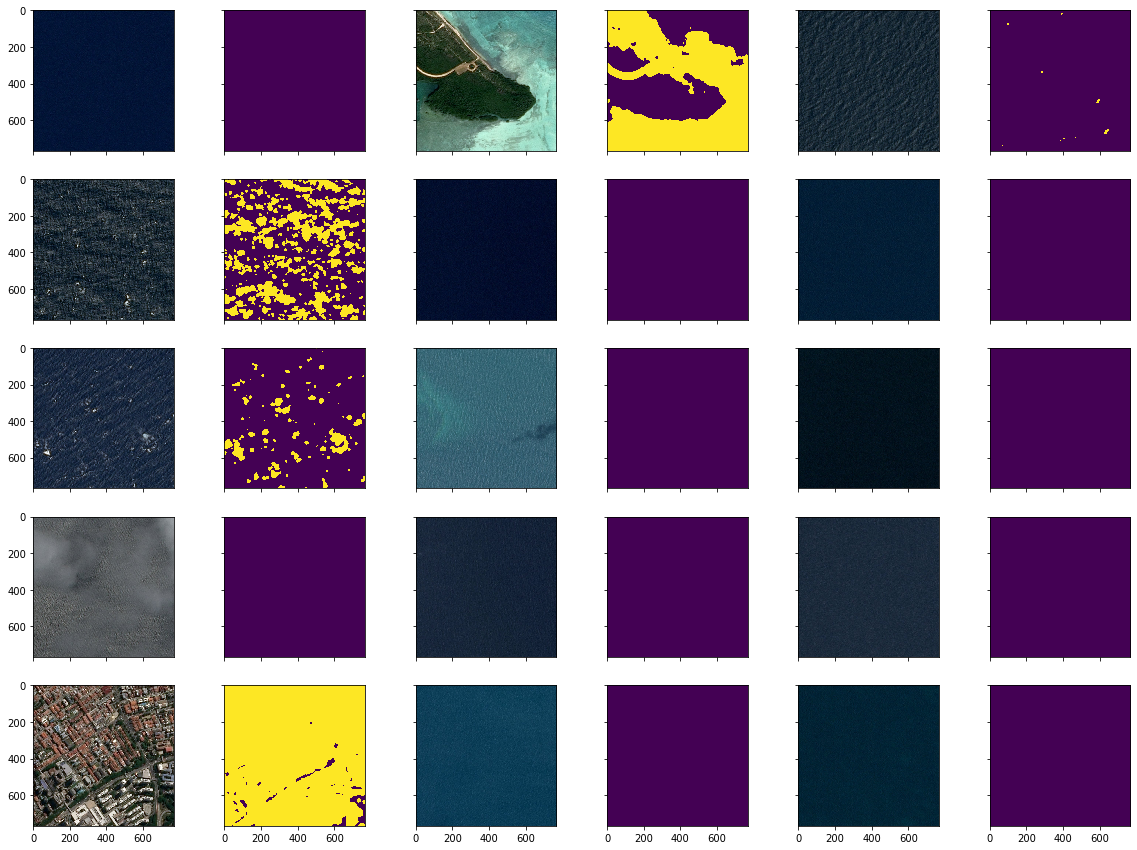

In [463]:
samples = df[~df['EncodedPixels'].isna()].sample(15)

fig, ax = plt.subplots(5, 6, figsize=(20, 15), sharex='col', sharey='row')

for i, idimg in enumerate(samples['ImageId']):
    col = i % 3
    row = i // 3
    
    path = 'D:/hackathon/train/train/{}'.format(idimg)
    img = cv2.imread(path)
    
    ax[row, col*2].imshow(img[...,[2,1,0]])
    ax[row, col*2+1].imshow(segnet_model.predict(np.stack([img], 0)/255.0)[0,:,:,0]>.5)